<a href="https://colab.research.google.com/github/AndreWerneck/MachineLearning/blob/main/ChurnDetection_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


> *Sujet* : **Détéction de l'attrition au sein d'une banque de détail (Churn detection in a retail bank)**


> *Date* : 16/11/2023


---



# 0. Imports et télécharger les données

Les bibliothèques ci-dessous sont toutes celles qui sont nécessaires pour faire fonctionner le projet. **Comme le projet a été créé avec Google Colab, je recommande de l'utiliser pour exécuter le code** pour des raisons de simplicité et pour éviter tout problème de dépendance ou de version.

In [ ]:
# required imports for the project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score

In [ ]:
#loading dataset
# local path
DATA_PATH = '/content/sample_data/dataset.csv'

data = pd.read_csv(DATA_PATH, sep =';',index_col=0) # id_client will be the index of our dataframe.
print(data.shape)
# data.head()

(7043, 62)


# 1. Analyse Exploratoire des Données (AED) #


J'ai commencé le projet par une analyse exploratoire des données, dans le but de trouver les principales caractéristiques des données, telles que les distributions de chaque variable, la quantité de données manquantes, la présence de valeurs aberrantes et la relation de chaque variable avec la variable cible. Il convient de noter que, pour des raisons de présentation et de taille du notebook, seules les cinq premières lignes de chaque tableau sont représentées ici.

### 1.1 l'Équilibre ou le déséquilibre de la variable cible

In [ ]:
# Calculating the number of samples and proportion of each class of the target variable in the dataset
class_counts = data['churn'].value_counts()
class_proportions = data['churn'].value_counts(normalize=True)
class_counts, class_proportions

(non    5174
 oui    1869
 Name: churn, dtype: int64,
 non    0.73463
 oui    0.26537
 Name: churn, dtype: float64)

### 1.2 Analyse des types des données, des valeurs uniques et des valeurs manquantes

In [ ]:
# checking percentual of null data, amount of unique values and data types
# Checking for missing values in the dataset
missing_values = data.isnull().sum()

# Getting a summary of data types and unique values in each column
data_summary = pd.DataFrame({
    'Data Type': data.dtypes,
    'Unique Values': data.nunique(),
    'Missing Values': missing_values,
    'Missing Values (%)': (missing_values / len(data)) * 100
})

data_summary.sort_values(by='Missing Values (%)', ascending=False).head()


,Data Type,Unique Values,Missing Values,Missing Values (%)
type,object,2,1807,25.656680
var_18,float64,6870,173,2.456340
var_15,float64,6882,161,2.285958
var_2,float64,6885,158,2.243362
segment_client,object,15,157,2.229164


### 1.3 Analyse des métriques statistiques basiques

In [ ]:
# Generating descriptive statistics for numerical variables

# converting numerical data that is encoded as string
data['interet_compte_epargne_total'] = pd.to_numeric(data['interet_compte_epargne_total'],errors='coerce')
numerical_summary = data.describe()
numerical_summary.transpose()[1:].head()

,count,mean,std,min,25%,50%,75%,max
anciennete_mois,6909.0,32.378926,24.572971,0.000000,9.000000,29.000000,55.000000,72.000000
agios_6mois,6896.0,64.761615,30.101904,18.250000,35.500000,70.325000,89.900000,118.750000
interet_compte_epargne_total,6902.0,2284.702282,2267.269644,18.800000,402.525000,1398.425000,3801.600000,8684.800000
age,6889.0,43.608506,16.215077,20.000000,31.000000,40.000000,54.000000,121.000000
var_0,6893.0,7179.987046,5810.200728,0.767658,2711.797553,5761.948333,10136.583353,41438.097046


Nous pouvons voir que la variable âge a une valeur maximale de 121 ans, ce qui n'a pas beaucoup de sens et doit donc être considéré comme une valeur aberrante.

### 1.4 Distribuitions (variables numériques) et Graphique de frequence (variables categorièlles)

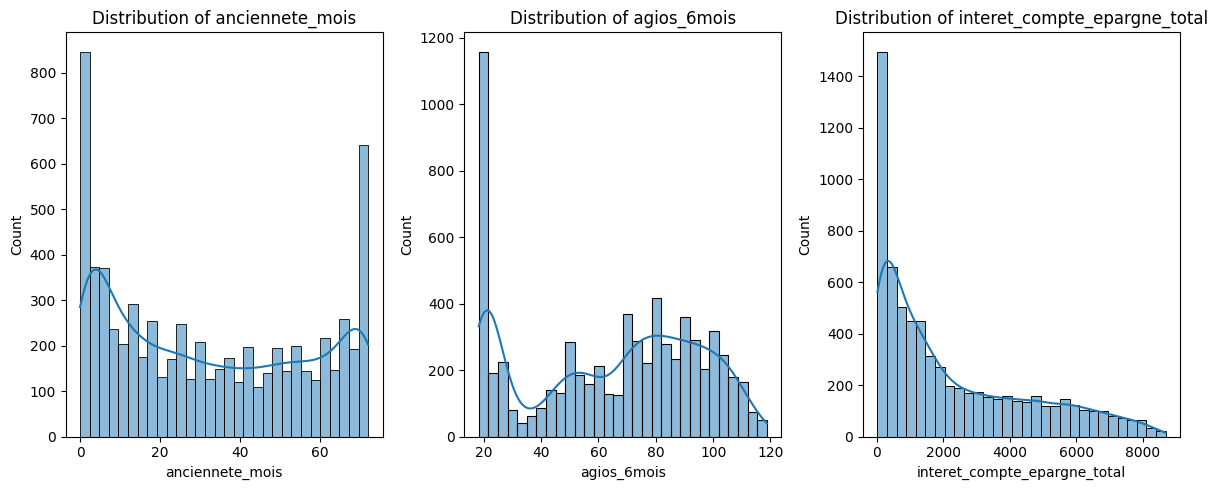

In [ ]:
# Plotting histograms for all numerical columns
NUM_COLUMNS_TO_PLOT = 3 # change to see more columns

numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns[1:NUM_COLUMNS_TO_PLOT+1]

num_plots = len(numerical_columns)
cols = 3  # define how many columns in your subplot grid
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(12, 5 * rows))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

plt.show()


On constate que les distributions des données sont variées. Par exemple, on constate que la distribution de l'anciennete_mois s'apparente à une distribution uniforme, alors que les distributions de l'âge et de l'interet_compte_epargne_total montrent une forte concentration sur la gauche de la courbe. De plus, nous avons vu que certaines variables sensibles ont des distributions très similaires et ressemblent à la distribution normale, ce qui peut être une indication d'une forte corrélation entre elles.

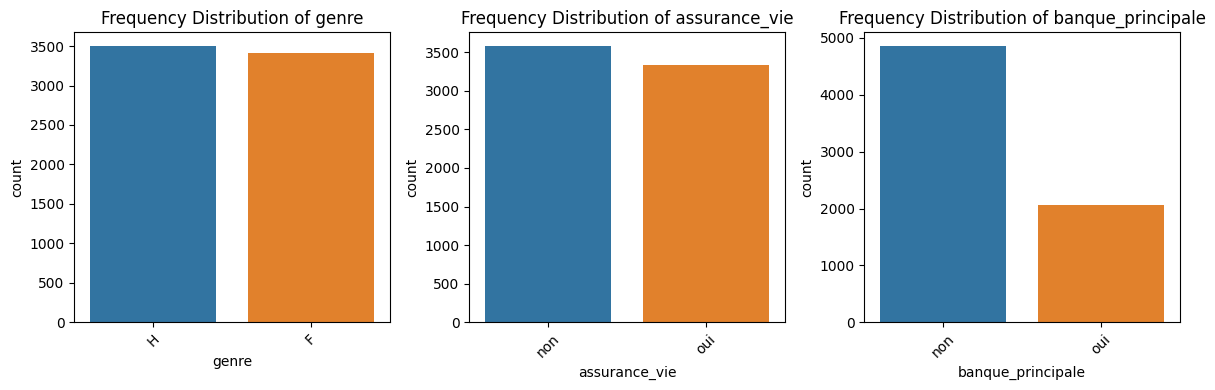

In [ ]:
# Plotting bar charts for all categorical columns
NUM_COLUMNS_TO_PLOT = 3

categorical_columns = data.select_dtypes(include=['object']).columns[:NUM_COLUMNS_TO_PLOT]
num_plots = len(categorical_columns)
cols = 3  # define how many columns in your subplot grid
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(12, 4 * rows))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(x=column, data=data)
    plt.title(f'Frequency Distribution of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()


Nous pouvons ici nous faire une idée de la distribution des variables catégorielles. Nous avons vu que certaines variables sont bien équilibrées, comme le genre et l'assurance_vie. Cependant, nous avons pu confirmer le déséquilibre de la variable cible et constater que d'autres classes étaient également assez déséquilibrées. Les distributions ci-dessus pour les variables catégorielles et numériques nous ont aidés à comprendre un peu mieux le profil des clients de notre banque de détail.

### 1.5 Rapport entre les variables numériques et catégorielles et la variable cible (taux de churn).

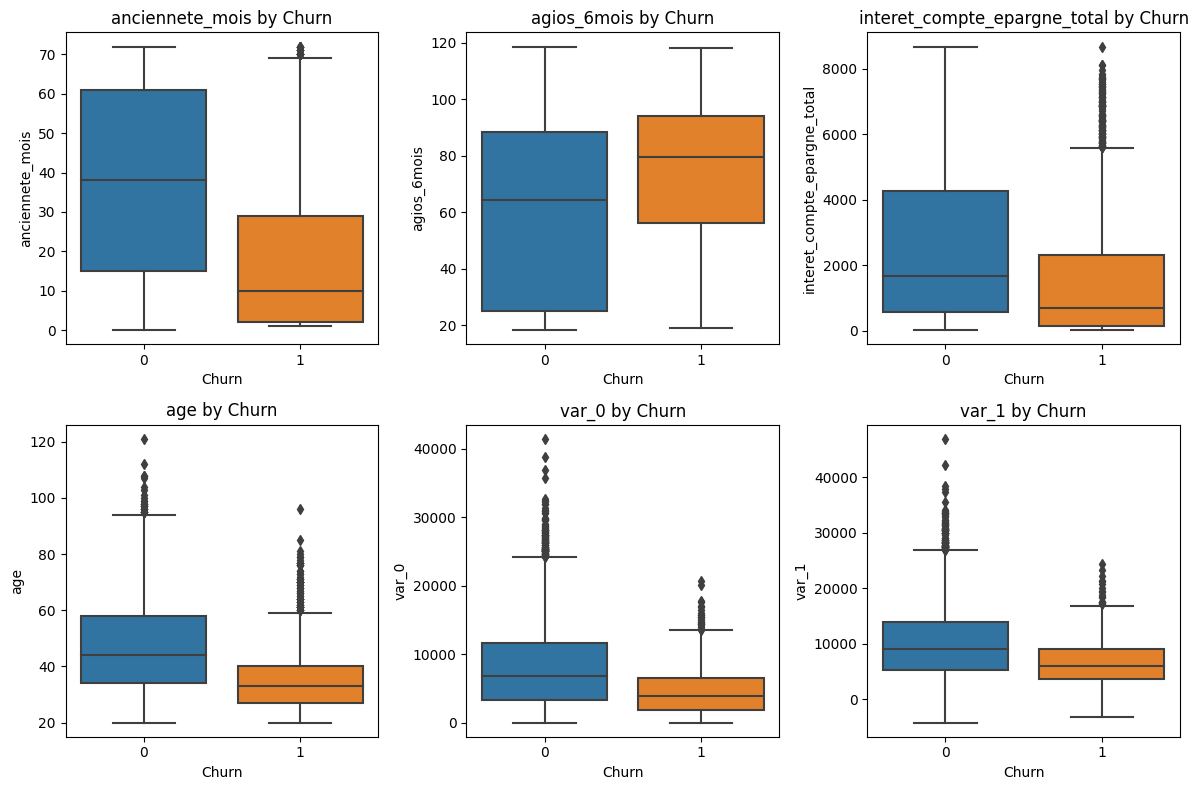

In [ ]:
# boxplots for numerical columns
N_COLUMNS_TO_PLOT = 6
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns[1:N_COLUMNS_TO_PLOT+1]

num_plots = len(numerical_columns)
cols = 3  # define how many columns in your subplot grid
rows = math.ceil(num_plots / cols)

data['churn_encoded'] = data['churn'].map({'oui': 1, 'non': 0})

# Re-plotting the box plots for numerical variables against churn
plt.figure(figsize=(12, 8))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x='churn_encoded', y=column, data=data) # targeting the relation of numeric variables with churn
    plt.title(f'{column} by Churn')
    plt.xlabel('Churn')
    plt.ylabel(column)

plt.tight_layout()
plt.show()


En examinant les boxplots, nous avons pu identifier que des variables telles que anciennete_mois et agios_6mois peuvent être de bons prédicteurs pour la variable cible churn, puisqu'elles présentent des différences significatives en termes de médiane et d'IQR pour chacune des classes de churn. Toutefois, nous avons également observé que certaines variables, comme certaines variables sensibles, par exemple, présentent un IQR et une médiane très similaires pour les deux catégories de désabonnement, ce qui indique qu'elles ne sont peut-être pas aussi utiles pour prédire notre variable cible.

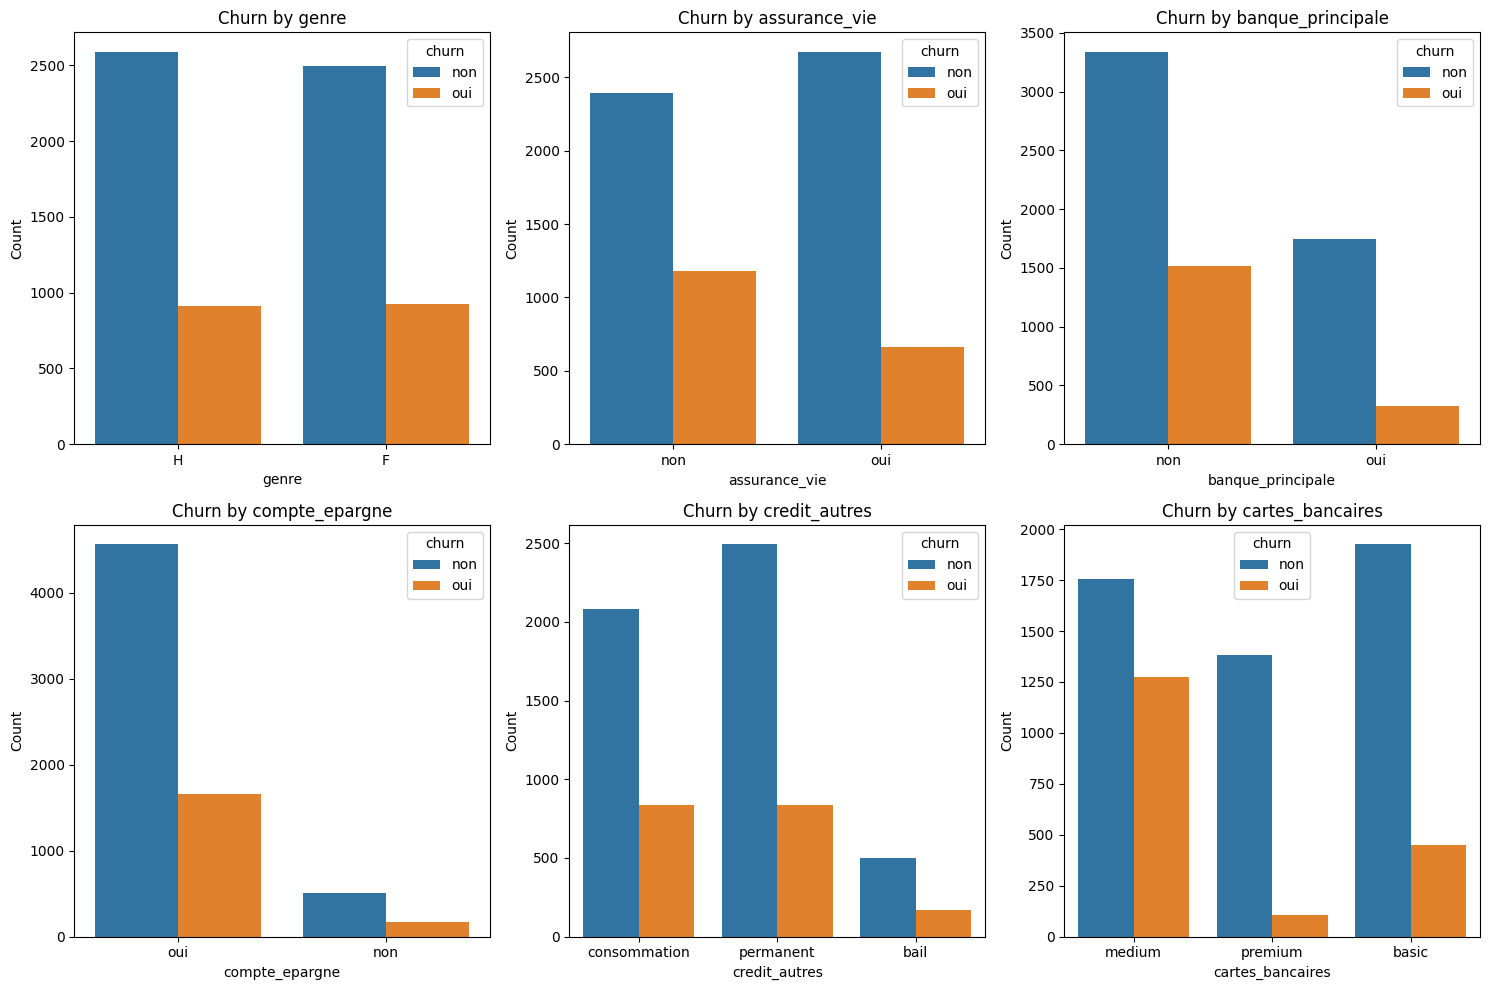

In [ ]:
# Analyzing the relationship between categorical variables and churn rate
NUM_COLUMNS_TO_PLOT = 7
categorical_columns = data.select_dtypes(include=['object']).columns[:NUM_COLUMNS_TO_PLOT]

plt.figure(figsize=(15, 10))

num_plots = len(categorical_columns[:-1])
cols = 3  # define how many columns in your subplot grid
rows = math.ceil(num_plots / cols)

for i, column in enumerate(categorical_columns[:-1], 1):  # excluding 'churn' itself
    plt.subplot(rows, cols, i)
    sns.countplot(x=column, hue='churn', data=data)
    plt.title(f'Churn by {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


De même, l'analyse des diagrammes à barres nous a permis d'observer des relations intéressantes. Par exemple, nous constatons une bonne asymétrie en matière de résiliation lorsque nous examinons les clients qui n'ont pas de compte courant ou qui n'ont pas notre banque comme banque principale. Les clients qui n'ont pas de compte courant et qui n'ont pas notre banque comme banque principale, ainsi que les clients qui sont plus fréquemment contactés par e-mail, ont un taux de résiliation plus élevé que les clients complémentaires, ce qui est tout à fait logique. En outre, nous avons observé des variables telles que le sexe et credit_immo, pour lesquelles le taux de résiliation égal à 1 est très similaire dans les deux classes, ce qui indique une fois de plus que cet attribut n'est peut-être pas considéré comme un bon prédicteur pour notre variable cible.

### 1.6 Analyse de Corrélation

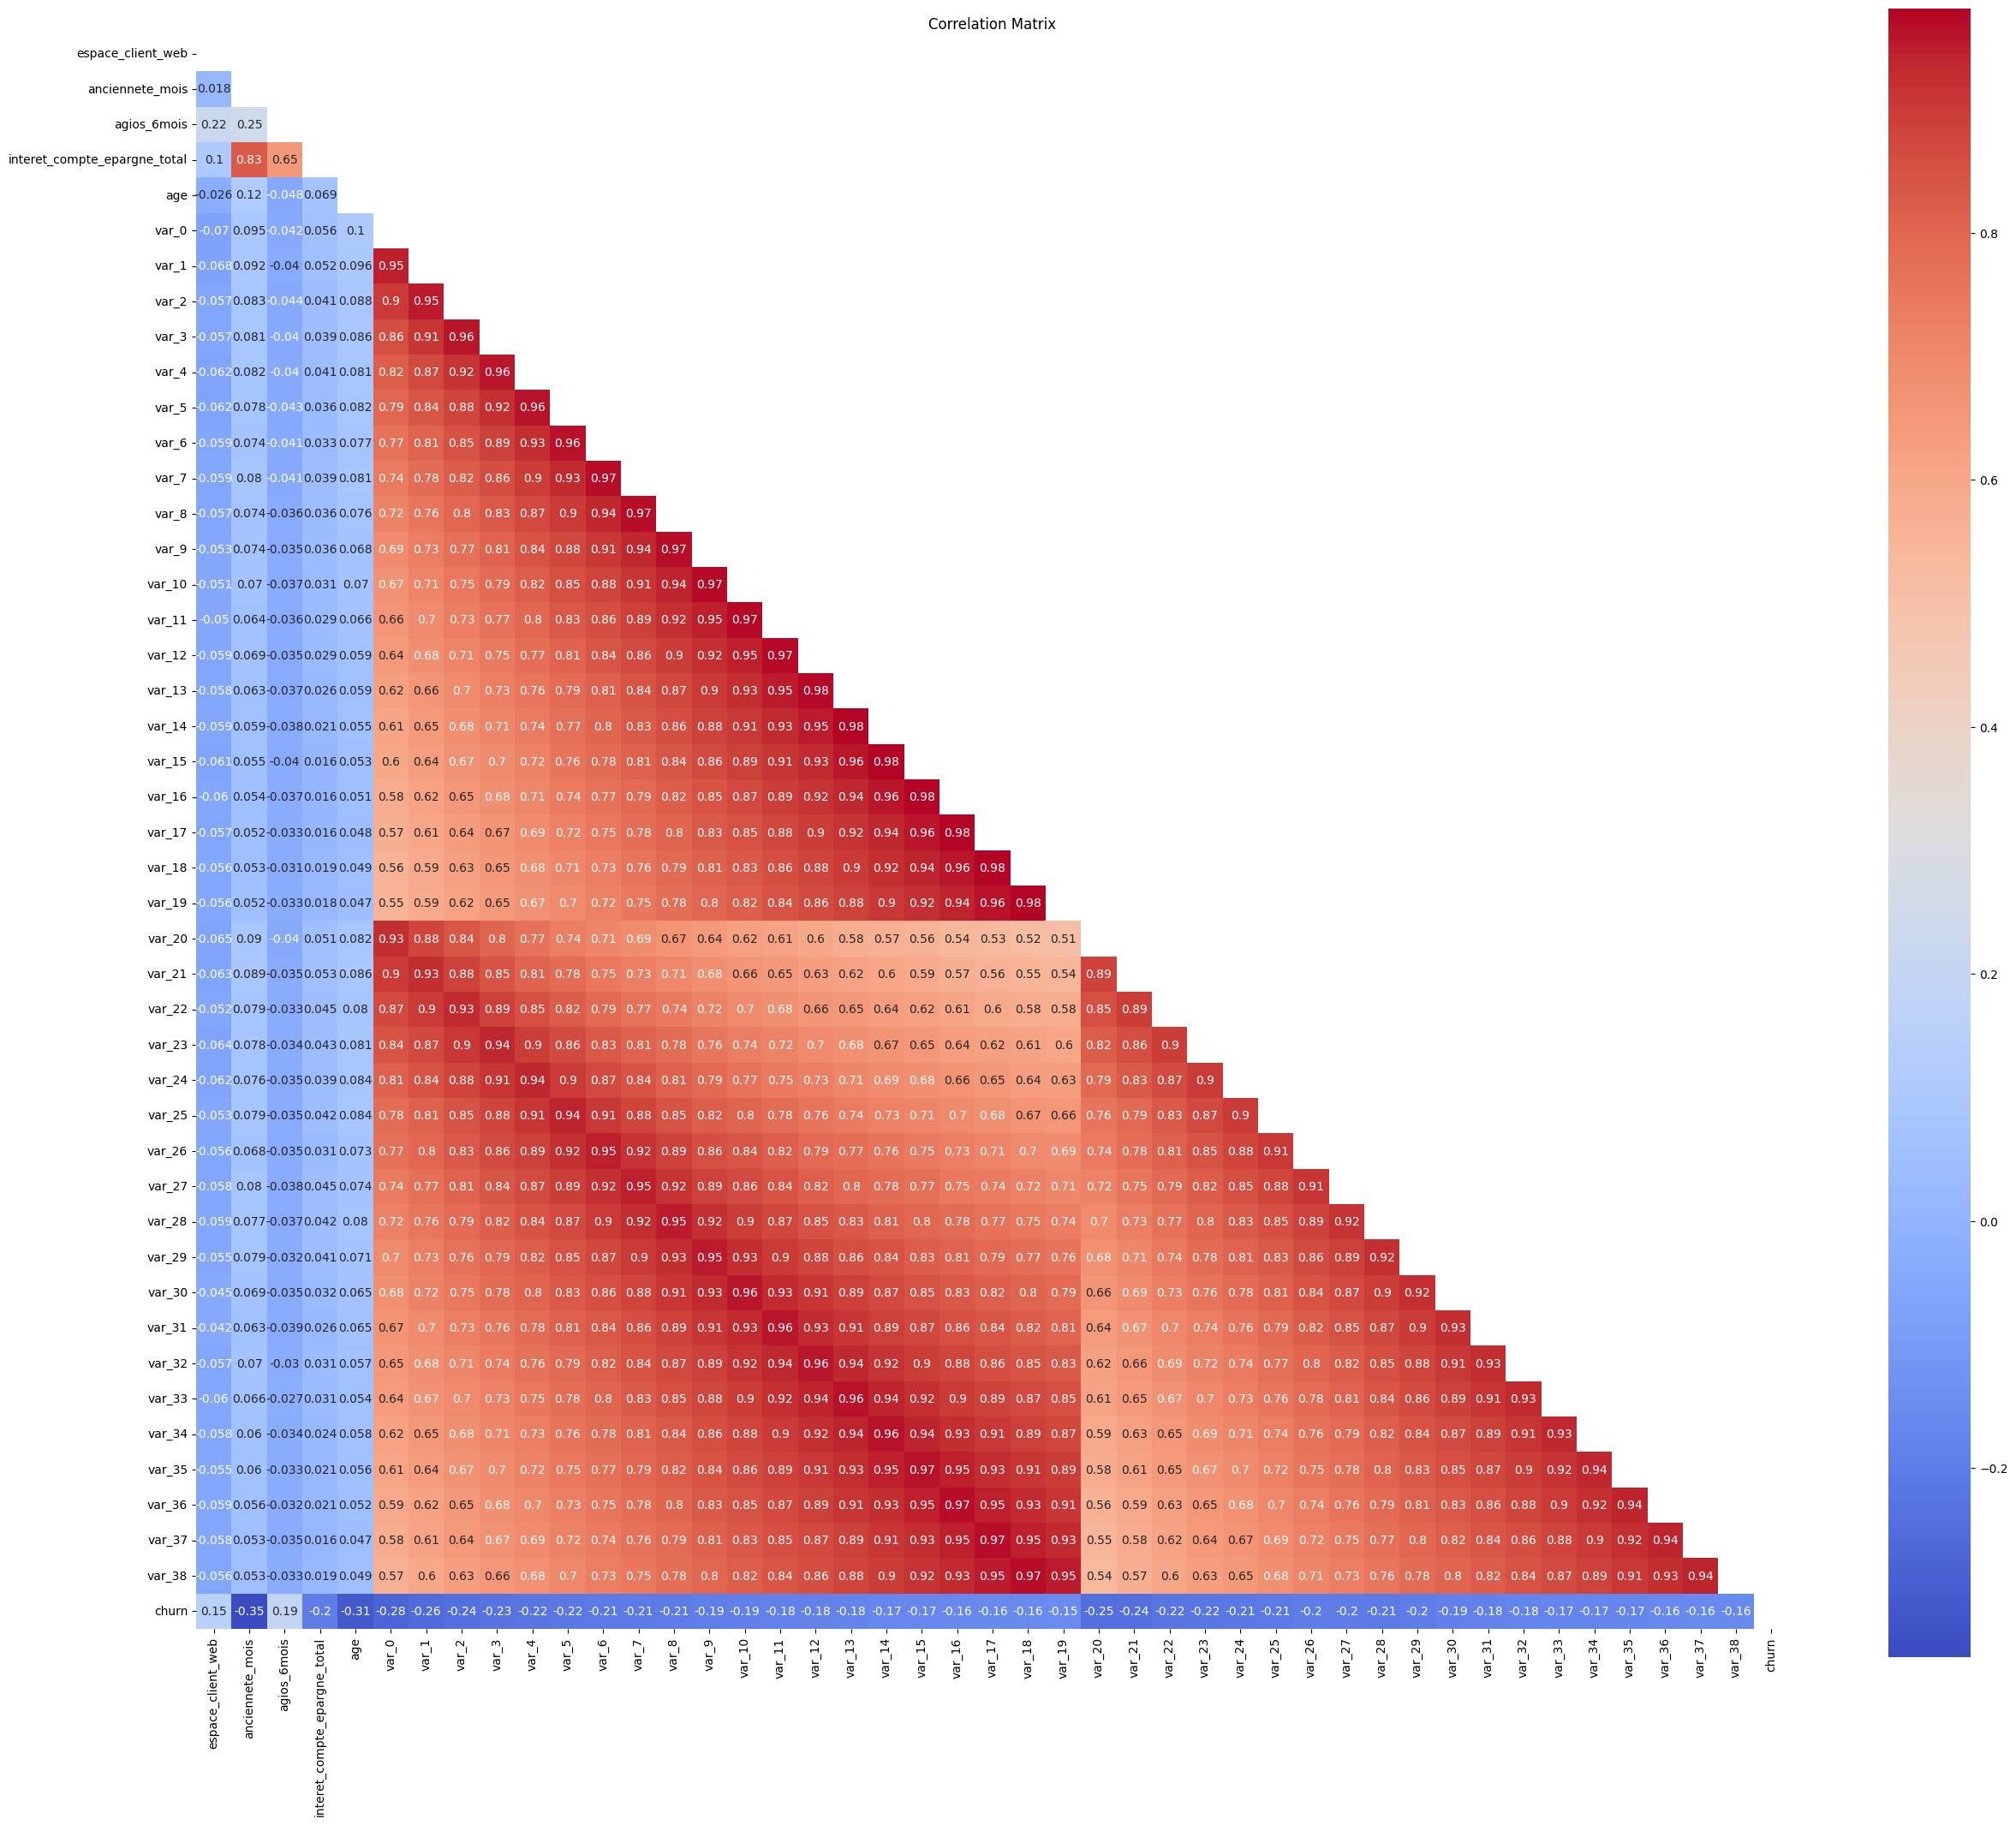

In [ ]:
# Converting the target variable 'churn' into a numerical format for correlation analysis
numerical_churn = data['churn'].map({'oui': 1, 'non': 0})

# Selecting a subset of numerical columns including the target variable for correlation analysis
numerical_columns_values = data.select_dtypes(include=['int64', 'float64']).iloc[:,:]

numerical_columns_for_corr = pd.concat([numerical_columns_values.drop(['churn_encoded'],axis=1),numerical_churn],axis=1)
# print(numerical_columns_for_corr.columns)

# # Calculating correlation matrix
correlation_matrix = numerical_columns_for_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# # Plotting the correlation matrix
plt.figure(figsize=(30, 25))
sns.heatmap(correlation_matrix, mask=mask ,annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()


L'analyse des corrélations nous a permis de confirmer certains de nos soupçons. Les variables sensibles sont extrêmement corrélées, comme nous avons pu le constater précédemment, également en examinant les distributions des données. Nous pouvons dire qu'elles peuvent présenter une forte multicolinéarité, ce qui se produit lorsque deux variables sont fortement corrélées. Le problème est que cela peut entraver la prédiction du modèle de classification, car cette multicollinéarité peut brouiller quelque peu le modèle et rendre difficile le calcul de ses coefficients. Il est également clair que les autres variables numériques n'ont pas de relation linéaire forte avec la variable churn, puisque les corrélations entre elles sont faibles.  

# 2. Sélection de Caractéristiques

### 2.1 Évitant la multicollinéarité

Après avoir effectué l'EDA, il a été possible de constater qu'il serait probablement nécessaire de supprimer certaines variables et de bien sélectionner les caractéristiques qui composeraient notre modèle afin de maximiser sa performance et d'attribuer le score de churn le plus correct possible aux nouveaux clients. Ainsi, nous avons commencé par retirer les paires extrêmement corrélées (corrélation > 90%) afin d'éviter le problème de multicollinéarité dans le modèle.

In [ ]:
# Identifying highly correlated pairs
# Setting a threshold for high correlation (e.g., above 0.9 or below -0.9)
threshold = 0.9

# Finding pairs of highly correlated features
highly_corr_pairs = correlation_matrix.abs().stack().reset_index()
highly_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
highly_corr_pairs = highly_corr_pairs[(highly_corr_pairs['Feature1'] != highly_corr_pairs['Feature2']) &
                                      (highly_corr_pairs['Correlation'] > threshold)]

# Sorting the pairs by correlation
highly_corr_pairs = highly_corr_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

highly_corr_pairs.head(10)  # Displaying the top 10 pairs for brevity


,Feature1,Feature2,Correlation
0,var_18,var_19,0.981651
1,var_19,var_18,0.981651
2,var_18,var_17,0.980413
3,var_17,var_18,0.980413
4,var_15,var_16,0.979399
5,var_16,var_15,0.979399
6,var_17,var_16,0.979283
7,var_16,var_17,0.979283
8,var_14,var_15,0.978260
9,var_15,var_14,0.978260


In [ ]:
# Creating a function to remove one variable from each highly correlated pair
def remove_highly_correlated_features(df, corr_pairs):
    # Set to keep track of features to be removed
    features_to_remove = set()

    for _, row in corr_pairs.iterrows():
        # Add one feature from each pair to the set
        if row['Feature1'] not in features_to_remove and row['Feature2'] not in features_to_remove:
            features_to_remove.add(row['Feature1'])

    # Removing the selected features from the dataframe
    df_reduced = df.drop(columns=list(features_to_remove))
    return df_reduced,features_to_remove

# Removing highly correlated features
data_reduced, removed_features = remove_highly_correlated_features(data, highly_corr_pairs)

# Displaying the shape of the original and reduced dataset
original_shape = data.shape
reduced_shape = data_reduced.shape

print(original_shape, reduced_shape)
print(removed_features)

(7043, 63) (7043, 31)
{'var_33', 'var_16', 'var_6', 'var_13', 'var_10', 'var_35', 'var_20', 'var_29', 'var_38', 'var_17', 'var_7', 'var_4', 'var_15', 'var_32', 'var_9', 'var_23', 'var_28', 'var_12', 'var_2', 'var_18', 'var_11', 'var_5', 'var_25', 'var_1', 'var_37', 'var_3', 'var_14', 'var_30', 'var_27', 'var_36', 'var_19', 'var_8'}


Nous avons pu remarquer que seules certaines des variables sensibles ont été retirées, précisément celles extrêmement corrélées.

### 2.2 Tests Statistiques

Dans le but d'approfondir notre sélection de caractéristiques, j'ai réalisé des tests de t-student et de chi-square sur les variables numériques et catégoriques, respectivement, afin d'évaluer s'il y avait une différence significative entre chaque attribut dans les catégories de churn et de non-churn. J'ai attribué un niveau de signification (alpha) de 0,05. Si la valeur p était supérieure à 0,05, nous considérerions qu'il n'y avait pas de différence significative pour qu'une variable puisse être considérée comme un bon prédicteur de churn. Et, dans ce cas, elle serait retirée.

In [ ]:
# T-tests for numerical variables
# We'll test if there's a significant difference in means of these variables between churned and non-churned clients
data_reduced['churn_encoded'] = data_reduced['churn'].map({'oui': 1, 'non': 0})

# Filtering data for churned and non-churned clients
churned = data_reduced[data_reduced['churn_encoded'] == 1]
non_churned = data_reduced[data_reduced['churn_encoded'] == 0]

numerical_columns = data_reduced.select_dtypes(include=['int64', 'float64']).columns[:-1]
# Performing t-tests for numerical variables
t_test_results = {}
for column in numerical_columns:
    t_stat, p_val = ttest_ind(churned[column].dropna(), non_churned[column].dropna())
    t_test_results[column] = {'t_statistic': round(t_stat), 'p_value': p_val>0.05}

t_test_results

{'espace_client_web': {'t_statistic': 13, 'p_value': False},
 'anciennete_mois': {'t_statistic': -31, 'p_value': False},
 'agios_6mois': {'t_statistic': 16, 'p_value': False},
 'interet_compte_epargne_total': {'t_statistic': -17, 'p_value': False},
 'age': {'t_statistic': -27, 'p_value': False},
 'var_0': {'t_statistic': -24, 'p_value': False},
 'var_21': {'t_statistic': -20, 'p_value': False},
 'var_22': {'t_statistic': -19, 'p_value': False},
 'var_24': {'t_statistic': -18, 'p_value': False},
 'var_26': {'t_statistic': -17, 'p_value': False},
 'var_31': {'t_statistic': -15, 'p_value': False},
 'var_34': {'t_statistic': -14, 'p_value': False}}

In [ ]:
# Chi-square tests for categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns
# Conducting Chi-square tests to assess the association between each categorical variable and churn
chi_square_results = {}
for column in categorical_columns:
    contingency_table = pd.crosstab(data[column], data['churn'])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    chi_square_results[column] = {'chi2_statistic': chi2, 'p_value': p_val>0.05}

chi_square_results

{'genre': {'chi2_statistic': 0.8088802362303127, 'p_value': True},
 'assurance_vie': {'chi2_statistic': 154.07460642783388, 'p_value': False},
 'banque_principale': {'chi2_statistic': 181.3299034141012, 'p_value': False},
 'compte_epargne': {'chi2_statistic': 0.943387268532842, 'p_value': True},
 'credit_autres': {'chi2_statistic': 10.89853058460848, 'p_value': False},
 'cartes_bancaires': {'chi2_statistic': 726.5508518922263, 'p_value': False},
 'compte_courant': {'chi2_statistic': 828.9965813888399, 'p_value': False},
 'compte_joint': {'chi2_statistic': 595.5950607939717, 'p_value': False},
 'PEA': {'chi2_statistic': 539.3640679427399, 'p_value': False},
 'assurance_auto': {'chi2_statistic': 818.6599387831048, 'p_value': False},
 'assurance_habitation': {'chi2_statistic': 367.8957004435865,
  'p_value': False},
 'credit_immo': {'chi2_statistic': 366.2696470973468, 'p_value': False},
 'type': {'chi2_statistic': 453.78118580181257, 'p_value': False},
 'compte_titres': {'chi2_statistic'

In [ ]:
data_reduced = data_reduced.drop(['compte_epargne','genre'],axis=1)
print(data_reduced.shape)
data_reduced.head()

(7043, 29)


,espace_client_web,assurance_vie,banque_principale,anciennete_mois,credit_autres,cartes_bancaires,compte_courant,compte_joint,PEA,assurance_auto,...,var_0,var_21,var_22,var_24,var_26,var_31,var_34,branche,churn,churn_encoded
id_client,,,,,,,,,,,,,,,,,,,,,
3463,0.0,non,non,37.0,consommation,medium,oui,non,non,non,...,3788.182745,1476.735096,2906.612116,6541.289876,8529.610222,13545.535937,9013.777747,NORD-OUEST,non,0
1869,0.0,oui,oui,72.0,consommation,premium,inconnu,inconnu,inconnu,inconnu,...,13256.481090,2893.438448,4522.323311,8409.097755,6615.523133,14014.989673,15470.524076,NORD-OUEST,non,0
3760,0.0,non,non,3.0,NaN,medium,non,non,oui,non,...,6485.760225,2194.386006,4719.557270,6652.559765,10784.182742,17239.846026,24084.291026,NORD-OUEST,non,0
3820,1.0,oui,non,72.0,consommation,medium,oui,oui,oui,oui,...,3023.518886,300.647893,NaN,1411.534141,4837.868424,9229.470887,11791.353542,NORD-OUEST,non,0
1463,0.0,non,non,4.0,permanent,medium,non,non,non,non,...,5108.994106,977.257244,782.571668,2025.910611,2883.741954,9008.641700,8026.508871,NORD-OUEST,oui,1


Après les deux tests statistiques, nous avons constaté que nous pourrions encore retirer deux variables catégoriques, car il n'y avait pas de différence significative entre leurs classes lorsqu'elles étaient agrégées selon les classes de churn. De cette manière, en analysant ces attributs, le modèle ne serait pas capable de distinguer suffisamment entre le churn et le non-churn à partir d'eux, les rendant statistiquement superflus dans notre cas.

# 3. Profil des Clients

In [ ]:
# Calculate the mode for categorical columns
categorical_columns = data_reduced.select_dtypes(include=['object']).columns

# Calculate the mean for numerical columns
numerical_columns = data_reduced.select_dtypes(include=['float64', 'int64']).columns

# Computing average client profile
categorical_modes_all = data_reduced[categorical_columns].mode().iloc[0]
numerical_means_all = data_reduced[numerical_columns].mean().drop(labels=[col for col in numerical_columns if col.startswith('var_') or col == 'churn_encoded'])
average_client_profile_all = pd.concat([categorical_modes_all, numerical_means_all])

# No churn clients average profile (churn = 0)
non_churn_data = data_reduced[data_reduced['churn'] == 'non']
categorical_modes_non_churn = non_churn_data[categorical_columns].mode().iloc[0]
numerical_means_non_churn = non_churn_data[numerical_columns].mean().drop(labels=[col for col in numerical_columns if col.startswith('var_') or col == 'churn_encoded'])
average_client_profile_non_churn = pd.concat([categorical_modes_non_churn, numerical_means_non_churn])

# Churn clients average profile (churn = 1)
churn_data = data_reduced[data_reduced['churn'] == 'oui']
categorical_modes_churn = churn_data[categorical_columns].mode().iloc[0]
numerical_means_churn = churn_data[numerical_columns].mean().drop(labels=[col for col in numerical_columns if col.startswith('var_') or col == 'churn_encoded'])
average_churn_client_profile = pd.concat([categorical_modes_churn, numerical_means_churn])

# Criar um DataFrame com as três colunas
profiles_comparison_df = pd.DataFrame({
    'Average Client Profile': average_client_profile_all,
    'Average Profile (Churn = 0)': average_client_profile_non_churn,
    'Average Profile (Churn = 1)': average_churn_client_profile
})

profiles_comparison_df

,Average Client Profile,Average Profile (Churn = 0),Average Profile (Churn = 1)
assurance_vie,non,oui,non
banque_principale,non,non,non
credit_autres,permanent,permanent,permanent
cartes_bancaires,medium,basic,medium
compte_courant,non,non,non
compte_joint,non,oui,non
PEA,non,non,non
assurance_auto,non,non,non
assurance_habitation,non,oui,non
credit_immo,non,oui,non


Après avoir éliminé les caractéristiques, il a été possible d'obtenir une image plus claire des différents profils de clients que nous avons. En établissant les profils des clients moyens, des clients non-churn et des clients oui-churn, nous pouvons voir des différences claires qui ont beaucoup de sens logique. Par exemple, les churners sont plus jeunes, sont clients depuis moins longtemps, ont des taux plus élevés à payer et moins de revenus d'intérêts.

# 4. Prétraitement des Données #

### 4.1 Outliers

Comme nous ne pouvons supposer aucune distribution pour nos données en général, nous avons utilisé la méthode IQR pour détecter et corriger les valeurs aberrantes.

In [ ]:
# Outlier Handling
# We'll use the IQR method for detecting and handling outliers

# Function to calculate IQR and determine outlier thresholds
def outlier_thresholds(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Applying this to key numerical variables
outlier_bounds = {}
for column in numerical_columns_for_corr.columns[:-1]:
    lower_bound, upper_bound = outlier_thresholds(data, column)
    outlier_bounds[column] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}

# outlier_bounds


In [ ]:
# Capping the non-sensitive numerical variables
# Function to cap the values
def cap_values(row, column, lower_bound, upper_bound):
    if row[column] < lower_bound:
        return lower_bound
    elif row[column] > upper_bound:
        return upper_bound
    else:
        return row[column]

# Capping the values for each non-sensitive column
capped_columns = ['anciennete_mois', 'agios_6mois', 'age', 'interet_compte_epargne_total']
for column in capped_columns:
    lower_bound = outlier_bounds[column]['lower_bound']
    upper_bound = outlier_bounds[column]['upper_bound']
    data[column] = data.apply(lambda row: cap_values(row, column, lower_bound, upper_bound), axis=1)

# Checking the effect of capping by displaying the descriptive statistics of the capped columns
data[capped_columns].describe()


,anciennete_mois,agios_6mois,age,interet_compte_epargne_total
count,6909.000000,6896.000000,6889.000000,6902.000000
mean,32.378926,64.761615,43.545507,2284.702282
std,24.572971,30.101904,16.016148,2267.269644
min,0.000000,18.250000,20.000000,18.800000
25%,9.000000,35.500000,31.000000,402.525000
50%,29.000000,70.325000,40.000000,1398.425000
75%,55.000000,89.900000,54.000000,3801.600000
max,72.000000,118.750000,88.500000,8684.800000


Nous avons pu constater que les valeurs aberrantes ont été corrigées en fonction des limites minimales et maximales de l'IQR, mais que la grande majorité des données n'ont pas été détectées comme aberrantes et sont donc restées intactes.

### 4.2 Valeurs manquantes

In [ ]:
# Handling missing values
# Function to perform proportional imputation
def proportional_imputation(data,column):
    # Getting the distribution of the existing non-null values
    distribution = data[column].dropna().value_counts(normalize=True)
    # Randomly filling missing values in 'type' according to the existing distribution
    missing = data[column].isnull()
    data.loc[missing, column] = np.random.choice(distribution.index,
                                                 size=len(data[missing]),
                                                 p=distribution.values)

# We will use the mode (most frequent value) for categorical variables
# and the median for numerical variables

# List of remaining columns with missing values
remaining_columns_with_missing = data_reduced.columns[data_reduced.isnull().any()].tolist()

# Imputing missing values
for column in remaining_columns_with_missing:
    # Check if the column is numerical or categorical
    if data_reduced[column].dtype == 'object':
        # Categorical: impute with proportional imputation
        proportional_imputation(data_reduced,column)
    else:
        # Numerical: impute with median
        median_value = data_reduced[column].median()
        data_reduced[column].fillna(median_value, inplace=True)
# Checking the results of the imputation
(data_reduced.isnull().sum()==0).all() # Displaying the count of missing values for all columns again

True

Pour les valeurs manquantes, nous avons supposé deux mesures, une pour chaque type de variable. Pour les variables numériques, la médiane a été choisie pour être placée là où il n'y avait pas de valeur. Pour les variables catégorielles, l'allocation proportionnelle des données a été choisie, afin de conserver globalement les mêmes caractéristiques de la distribution initiale et donc de ne pas biaiser le modèle.

### 4.3. Encodage de données catégorielles  

In [ ]:
label_encoder = LabelEncoder()
#label-encoding categorical data
categorical_columns = data_reduced.select_dtypes(include=['object']).columns
for column in categorical_columns:
    data_reduced[column] = label_encoder.fit_transform(data_reduced[column])

data_reduced.head()

,espace_client_web,assurance_vie,banque_principale,anciennete_mois,credit_autres,cartes_bancaires,compte_courant,compte_joint,PEA,assurance_auto,...,var_0,var_21,var_22,var_24,var_26,var_31,var_34,branche,churn,churn_encoded
id_client,,,,,,,,,,,,,,,,,,,,,
3463,0.0,0,0,37.0,1,1,2,1,1,1,...,3788.182745,1476.735096,2906.612116,6541.289876,8529.610222,13545.535937,9013.777747,2,0,0
1869,0.0,1,1,72.0,1,2,0,0,0,0,...,13256.481090,2893.438448,4522.323311,8409.097755,6615.523133,14014.989673,15470.524076,2,0,0
3760,0.0,0,0,3.0,2,1,1,1,2,1,...,6485.760225,2194.386006,4719.557270,6652.559765,10784.182742,17239.846026,24084.291026,2,0,0
3820,1.0,1,0,72.0,1,1,2,2,2,2,...,3023.518886,300.647893,2256.702045,1411.534141,4837.868424,9229.470887,11791.353542,2,0,0
1463,0.0,0,0,4.0,2,1,1,1,1,1,...,5108.994106,977.257244,782.571668,2025.910611,2883.741954,9008.641700,8026.508871,2,1,1


Pour encoder les valeurs catégoriques, comme dans la grande majorité des données les valeurs étaient oui ou non, ou n'avaient pas beaucoup de valeurs uniques (à l'exception de segment_client), la méthode choisie a été l'encodage par étiquetage, car elle est plus simple et n'ajoute aucune dimension au modèle.

### 4.4 Division et Normalisation des Données

In [ ]:
X = data_reduced.drop(['churn','churn_encoded'], axis=1)  # Features
y = data_reduced['churn']  # Target

# Splitting into train and test set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)

(5634, 27) (1409, 27)


La normalisation ici sera effectuée uniquement pour le modèle de régression logistique et elle sera réalisée en utilisant le framework Pipeline, qui aide le modèle à normaliser correctement pendant la validation croisée, évitant ainsi la fuite de données.

# 5. Modèles de classification

### 5.1 Régression Logistique

Le modèle de régression logistique est le plus simple, le plus rapide à entraîner et le plus facile à expliquer. De plus, il nous fournit directement un score d'importance clair et simple à interpréter. Ainsi, il a été le premier modèle à être entraîné et évalué.

In [ ]:
# Define the model
from imblearn.pipeline import Pipeline as ImbPipeline

# Create a pipeline with proper preprocessing and the model
pipeline = ImbPipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(random_state=42, max_iter=10000))
])

# performing Cross-validation
# Setting up Grid Search for hyperparameter tuning
param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l2'],
    'lr__class_weight': [None, 'balanced'],
    'lr__solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro',n_jobs=-1)

grid_search.fit(X_train, y_train)

# taking the best model the model
best_lr_model = grid_search.best_estimator_

In [ ]:
# Test set evaluation
y_test_pred = best_lr_model.predict(X_test)  # X_test should not be normalized beforehand
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
test_roc_auc = roc_auc_score(y_test, best_lr_model.predict_proba(X_test)[:, 1])
print(f"Test ROC-AUC Score: {test_roc_auc:.2f}")
print("Best Parameters:", grid_search.best_params_)

Test Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.79      0.85      1036
           1       0.58      0.79      0.67       373

    accuracy                           0.79      1409
   macro avg       0.74      0.79      0.76      1409
weighted avg       0.82      0.79      0.80      1409

Test Confusion Matrix:
 [[821 215]
 [ 79 294]]
Test ROC-AUC Score: 0.88
Best Parameters: {'lr__C': 100, 'lr__class_weight': None, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}


Cependant, nous pouvons attester de certaines choses concernant sa performance. Il a très bien performé pour la classe majoritaire (churn = 0), mais n'a pas obtenu une bonne précision pour la classe minoritaire. Un point positif est qu'il a présenté un bon recall et un bon score ROC-AUC, signifiant que même avec une faible précision, il parvient à séparer considérablement les deux classes. Il convient de dire ici que ces résultats sont communs pour les problèmes avec des données modérément ou très déséquilibrées, comme c'est notre cas. Enfin, il est important de souligner que plusieurs techniques ont été utilisées pour essayer de gérer ce problème. Les plus efficaces ont été de faire un suréchantillonnage des données en utilisant SMOTE et de rééquilibrer les classes dans le modèle (argument 'balanced'). Cependant, les données avec suréchantillonnage ont été plus efficaces pour le modèle et, par conséquent, cette méthodologie a été choisie.

### 5.2 Forêt Aléatoire

Une autre façon de traiter les données déséquilibrées était d'utiliser des modèles ensemblistes ou de gradient boosting, tels que les arbres, les forêts aléatoires ou le XGboost. Ainsi, un modèle de forêt aléatoire a également été entraîné pour être comparé à la régression logistique.

In [ ]:
from sklearn.utils import class_weight
# Initialize the Random Forest classifier

random_forest_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'class_weight' : [None,'balanced']
}

# performing Cross-validation
grid_search = GridSearchCV(
    estimator=random_forest_model,
    param_grid=param_grid,
    scoring='f1',  # Use the appropriate evaluation metric
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    verbose=2,  # Increase verbosity for progress updates
)

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [ ]:
# Evaluate the model
y_test_pred_rf = best_rf_model.predict(X_test)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred_rf))
test_confusion_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
print("Confusion Matrix:\n", test_confusion_matrix_rf)
# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("Best Parameters:", grid_search.best_params_)

Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      1036
           1       0.65      0.74      0.69       373

    accuracy                           0.83      1409
   macro avg       0.78      0.80      0.79      1409
weighted avg       0.84      0.83      0.83      1409

Confusion Matrix:
 [[886 150]
 [ 96 277]]
ROC-AUC Score: 0.89
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


En analysant la performance de la forêt aléatoire, nous avons pu observer une amélioration considérable. Comme prévu, étant un modèle de bagging, il est moins sensible aux classes déséquilibrées et, par conséquent, présente des métriques plus robustes et une performance plus stable. Cependant, il est important de noter que même si ce modèle est plus résistant au problème des classes déséquilibrées, le meilleur modèle était celui avec class_weights = 'balanced', montrant que le problème n'est pas complètement résolu juste en changeant l'algorithme. Ici, nous n'avons pas fait de suréchantillonnage pour ne pas risquer le surajustement. Il convient également de dire que le redimensionnement des données n'est pas nécessaire pour les modèles basés sur les arbres et, par conséquent, cela n'a pas été fait.

### 5.3 XGBoost

XGBoost fonctionne en ajoutant séquentiellement des arbres, où chaque nouvel arbre tente de corriger les erreurs commises par les précédents. C'est une forme de boosting de gradient, qui se concentre sur l'optimisation d'une fonction de coût. Il surpasse généralement la forêt aléatoire, principalement dans les problèmes de déséquilibre. Et, vu que nous n'étions pas encore satisfaits de la performance de nos modèles, nous avons essayé de former un modèle XGBoost

In [ ]:
# Initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'class_weight':[None,'balanced']
}

# performing Cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',  # Use the appropriate evaluation metric
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    verbose=2,  # Increase verbosity for progress updates
)

grid_search.fit(X_train, y_train)

best_model_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


In [ ]:
# Evaluate the model on the test set
y_test_pred_xgb = best_model_xgb.predict(X_test)
print("Test Classification Report:\n",classification_report(y_test, y_test_pred_xgb))
test_confusion_matrix_xgb = confusion_matrix(y_test, y_test_pred_xgb)
print("Confusion Matrix:\n", test_confusion_matrix_xgb)
# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, best_model_xgb.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("Best Parameters:", grid_search.best_params_)

Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      1036
           1       0.77      0.70      0.74       373

    accuracy                           0.87      1409
   macro avg       0.84      0.81      0.82      1409
weighted avg       0.86      0.87      0.86      1409

Confusion Matrix:
 [[960  76]
 [112 261]]
ROC-AUC Score: 0.93
Best Parameters: {'class_weight': None, 'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}


Les résultats du XGBoost sont bien meilleurs, avec une précision et un rappel supérieurs à 70% pour la classe minoritaire. De plus, le modèle n'a pas eu besoin d'équilibrer les poids pour atteindre un tel résultat. Il convient de mentionner que, comme pour le modèle RandomForest (le XGBoost est également un modèle basé sur des arbres), aucune normalisation ni suréchantillonnage des données n'a été effectué. Ainsi, compte tenu de cette performance sur l'ensemble de test (ensemble jamais vu auparavant par le modèle), il sera choisi comme classificateur pour la tâche de score de churn

### 5.4 Sauvegarder le modèle

In [ ]:
with open('best_model_xgb.pkl','wb') as file:
    pickle.dump(best_model_xgb,file) # save your best model

# 6. Churn Score

In [ ]:
# computing churn score based on the probabilities from the best model
churn_probabilities = best_model_xgb.predict_proba(X_test)[:, 1]
#comparing our results with the labeled test data
churn_scores = pd.DataFrame({
    'churn_score': churn_probabilities,
    # 'y_test': y_test
},index=X_test.index)
# assert y_test.index.equals(churn_scores.index) # guarateeing that the comparison is being made at the same indexes
churn_scores = churn_scores.sort_values(by='churn_score', ascending=False)
churn_scores

,churn_score
id_client,
5538,0.998270
3527,0.997628
5100,0.997496
5826,0.996747
983,0.996624
...,...
2389,0.000370
3168,0.000354
956,0.000284


Avec les résultats du modèle de classification, nous avons un bon indicateur de score de churn pour notre banque de détail. Le score a été défini comme la probabilité que chaque client quitte la banque. Ainsi, les clients avec un score de 0.998 ont 99,8% de chances de ne plus être clients de la banque, information qui peut être utilisée par les employés pour essayer de prendre des mesures visant à retenir ce client et à inverser la situation. Il est important de souligner que, pour toutes nouvelles données, il suffit de les placer dans un fichier au même format que la base de données actuelle et de répéter toute l'analyse (ré-exécuter toutes les cellules du notebook) et, ainsi, le modèle nous informera avec un bon taux de réussite, la probabilité de churn d'un nouveau client. De plus, il a été envisagé d'attribuer des étiquettes à certaines valeurs de score de churn, mais il a été décidé que cela relève de l'interprétation du client.

### 6.1 Score d'importance des caractéristiques

In [ ]:
importances = best_model_xgb.feature_importances_
# coefficients = best_lr_model.coef_[0]

feature_names = X.columns # getting feature names
feature_importance_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_xgb = feature_importance_xgb.sort_values(by='Importance', ascending=False)
feature_importance_xgb

,Feature,Importance
3,anciennete_mois,0.094397
7,compte_joint,0.082815
12,type,0.082526
18,segment_client,0.076901
6,compte_courant,0.076868
17,age,0.070444
13,compte_titres,0.066423
5,cartes_bancaires,0.057234
19,var_0,0.055808
9,assurance_auto,0.050840


En analysant le score d'importance des caractéristiques, il est utile de revenir aux boxplots et aux graphiques à barres montrés dans la section d'Analyse Exploratoire des Données (AED). Les caractéristiques les plus déterminantes pour prédire la variable churn ont été bien capturées par le modèle et sont logiquement cohérentes. Ainsi, il est clair que des variables telles que la durée pendant laquelle le client est à la banque, le type de compte, le segment du client, son âge, avoir ou non un compte courant, sont des attributs fondamentaux pour essayer de retenir le client et peuvent jouer un rôle actif dans le renversement d'une situation de churn possible. Il convient de souligner la capacité du modèle à saisir les relations non linéaires présentes dans les données par rapport à la prédiction de la variable cible. De cette manière, je crois que je peux conclure que le modèle de score de churn a bien rempli son objectif. Merci pour l'opportunité !